<h1>Digit Recognizer Using Convolutional Neural Network</h1>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Setting the seaborn style
sns.set(style='white', context='notebook', palette='bright')

In [6]:
# Load the Data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

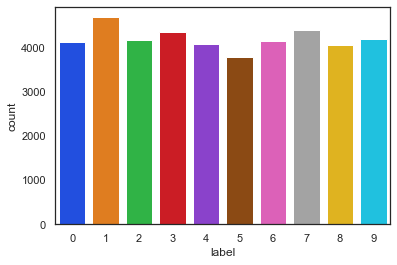

In [7]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

In [8]:
# Normalizing the data
X_train = X_train / 255.0
test = test / 255.0

In [9]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , channel = 1)
# -1 represents the no of examples
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [10]:
# Encode labels to one hot vectors (ex : 1 -> [0,1,0,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

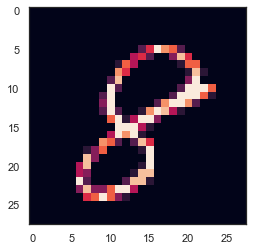

In [12]:
# Showing Some examples from training set
g = plt.imshow(X_train[0][:,:,0])

In [13]:
# Define the CNN model 
# The CNN architechture is Input -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Output

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [14]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2 = 0.999, epsilon=1e-07)

In [15]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [16]:
# Set annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [17]:
datagen = ImageDataGenerator(
        rotation_range=10, 
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1
        )

datagen.fit(X_train)

In [18]:
# Fit the model
batch_size = 86
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 40, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              )

Epoch 1/40
439/439 - 63s - loss: 0.4152 - accuracy: 0.8654 - val_loss: 0.0609 - val_accuracy: 0.9833
Epoch 2/40
439/439 - 60s - loss: 0.1355 - accuracy: 0.9603 - val_loss: 0.0418 - val_accuracy: 0.9867
Epoch 3/40
439/439 - 61s - loss: 0.0991 - accuracy: 0.9715 - val_loss: 0.0326 - val_accuracy: 0.9902
Epoch 4/40
439/439 - 60s - loss: 0.0841 - accuracy: 0.9745 - val_loss: 0.0275 - val_accuracy: 0.9921
Epoch 5/40
439/439 - 60s - loss: 0.0731 - accuracy: 0.9788 - val_loss: 0.0307 - val_accuracy: 0.9912
Epoch 6/40
439/439 - 60s - loss: 0.0672 - accuracy: 0.9804 - val_loss: 0.0273 - val_accuracy: 0.9907
Epoch 7/40
439/439 - 61s - loss: 0.0600 - accuracy: 0.9822 - val_loss: 0.0244 - val_accuracy: 0.9905
Epoch 8/40
439/439 - 60s - loss: 0.0585 - accuracy: 0.9830 - val_loss: 0.0220 - val_accuracy: 0.9921
Epoch 9/40
439/439 - 60s - loss: 0.0510 - accuracy: 0.9851 - val_loss: 0.0233 - val_accuracy: 0.9933
Epoch 10/40
439/439 - 61s - loss: 0.0503 - accuracy: 0.9849 - val_loss: 0.0223 - val_accura

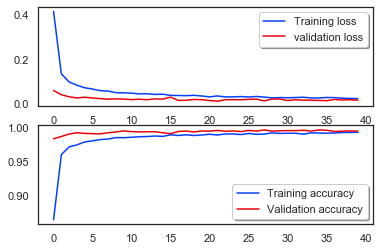

In [19]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

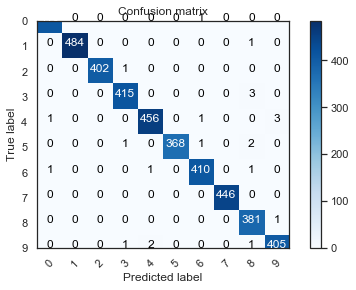

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

[8]


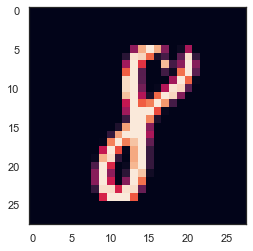

In [32]:
test_img_index = 52
plt.imshow(test[test_img_index][:,:,0])
img = np.expand_dims(test[test_img_index], axis=0)
pred = model.predict(img)
pred_class = np.argmax(pred,axis = 1)
print(pred_class)